# Test results

In [1]:
import numpy as np
import logging
import pickle
import dos

from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Define color and marker for analysis plots
markers = ["x", "+", "o"]
colors = ["blue","orange","green","red","purple","brown","pink"]



In [2]:
from ruamel import yaml
from ruamel.yaml import YAML
y = YAML()
y.default_flow_style = None

sim_folder = 'dos/SHWFS_ES'
with open(Path(sim_folder)/'M1.yaml','r') as stream:
        m1_x0_dt = yaml.safe_load(stream)
with open(Path(sim_folder)/'M2.yaml','r') as stream:
        m2_x0_dt = yaml.safe_load(stream)

# Function to compute reconstructor error        
def get_rec_error(m1_x0_dt, m2_x0_dt, controllerDT):
    M1Txyz = controllerDT['M1 Txyz'].timeSeries
    M1Rxyz = controllerDT['M1 Rxyz'].timeSeries
    M2Txyz = controllerDT['M2 Txyz'].timeSeries
    M2Rxyz = controllerDT['M2 Rxyz'].timeSeries
    M1BM = controllerDT['M1 BM'].timeSeries

    biasM1Txyz, biasM1Rxyz, biasM1BM = np.zeros((7,3,n_w)), np.zeros((7,3,n_w)), np.zeros((7,46,n_w))
    biasM2Txyz, biasM2Rxyz = np.zeros((7,3,n_w)), np.zeros((7,3,n_w))

    for kmode in range(3):
        for kseg in range(7):
            biasM1Txyz[kseg,kmode,:] = M1Txyz[1][kseg,kmode,-n_w:] + np.array(m1_x0_dt['state']['Txyz'])[kseg,kmode]
            biasM1Rxyz[kseg,kmode,:] = M1Rxyz[1][kseg,kmode,-n_w:] + np.array(m1_x0_dt['state']['Rxyz'])[kseg,kmode]
            biasM1BM[kseg,kmode,:] = M1BM[1][kseg,kmode,-n_w:] + np.array(m1_x0_dt['state']['modes'])[kseg,kmode]
            biasM2Txyz[kseg,kmode,:] = M2Txyz[1][kseg,kmode,-n_w:] + np.array(m2_x0_dt['state']['Txyz'])[kseg,kmode]
            biasM2Rxyz[kseg,kmode,:] = M2Rxyz[1][kseg,kmode,-n_w:] + np.array(m2_x0_dt['state']['Rxyz'])[kseg,kmode]
    
    error_mean = [np.linalg.norm(np.reshape(np.mean(biasM1Txyz, axis=2),21),1),
            np.linalg.norm(np.reshape(np.mean(biasM1Rxyz, axis=2),21),1),
            np.linalg.norm(np.reshape(np.mean(biasM1BM, axis=2),7*46),1),
            np.linalg.norm(np.reshape(np.mean(biasM2Txyz, axis=2),21),1),
            np.linalg.norm(np.reshape(np.mean(biasM2Rxyz, axis=2),21),1)]
    error_std = [sum(np.reshape(np.std(biasM1Txyz, axis=2),21)),
            sum(np.reshape(np.std(biasM1Rxyz, axis=2),21)),
            sum(np.reshape(np.std(biasM1BM, axis=2),7*46)),
            sum(np.reshape(np.std(biasM2Txyz, axis=2),21)),
            sum(np.reshape(np.std(biasM2Rxyz, axis=2),21))]
    
    return error_mean, error_std

In [60]:
# Guide star magnitudes to be investigated
mag_values = np.array([6, 8, 10, 12, 14, 16, 18, 20])
K = 0.25
n_w = 80

wfe_mean, wfe_std = [], []
pssn_mean, pssn_std = [], []
error_mean, error_std = [], []
#piston = [], []

# List of baseline reconstructor reconstructor
wfe_mean_, wfe_std_ = [], []
pssn_mean_, pssn_std_ = [], []
error_mean_, error_std_ = [], []

for imag in range(len(mag_values)):
    filename = 'dt_mag%d_ctrlK%sreg100_QP_rec_test.pickle'% (mag_values[imag],str(K).replace(".", "p"))
    #filename = 'dt_mag%d_ctrlK%sreg100_QP_recBMtest.pickle'% (mag_values[imag],str(K).replace(".", "p"))
    #filename = 'dt_mag%d_ctrlK%sreg100_QP_recRBMtest.pickle'% (mag_values[imag],str(K).replace(".", "p")) # rho_F = 1.
    #filename = 'dt_mag%d_ctrlK%sreg20RecM_reWM2_BMtest.pickle'% (mag_values[imag],str(K).replace(".", "p"))
    #filename = 'dt_mag%d_ctrlK%sreg20RecM_reWM2.pickle'% (mag_values[imag],str(K).replace(".", "p"))
    #filename = 'dt_mag%d_ctrlK%sreg20RecM_qp.pickle'% (mag_values[imag],str(K).replace(".", "p"))
    
    with open(Path('testDT')/filename,'rb') as f:
        dt = pickle.load(f)
            
    # WFE
    aux = dt['sim_log_dt']['science']['wfe_rms'].timeSeries[1][-n_w:]*1e6    
    wfe_mean.append(np.mean(aux))
    wfe_std.append(np.std(aux))
    # PSSn
    aux = dt['sim_log_dt']['science']['PSSn'].timeSeries[1][-n_w:]
    pssn_mean.append(np.mean(aux))
    pssn_std.append(np.std(aux))
    # Reconstructor error
    rec_error_mean, rec_error_std = get_rec_error(m1_x0_dt, m2_x0_dt, dt['sim_log_dt']['SHAcO_qp'])
    #rec_error_mean, rec_error_std = get_rec_error(m1_x0_dt, m2_x0_dt, dt['sim_log_dt']['SHAcO_qp'])
    error_mean.append(rec_error_mean), error_std.append(rec_error_std)
    
    # Load results using baseline estimator
    filename = 'dt_mag%d_ctrlK%sTSVD_rec_test.pickle'% (mag_values[imag],str(K).replace(".", "p"))
    #filename = 'dt_mag%d_ctrlK%sTSVD_TSVDRecM_BMtest.pickle'%(mag_values[imag],str(K).replace(".", "p"))
    #filename = 'dt_mag%d_ctrlK%sTSVDRecM.pickle'%(mag_values[imag],str(K).replace(".", "p"))
    
    with open(Path('testDT')/filename,'rb') as f:
        dt = pickle.load(f)
        
    # WFE
    aux = dt['sim_log_dt']['science']['wfe_rms'].timeSeries[1][-n_w:]*1e6    
    wfe_mean_.append(np.mean(aux))
    wfe_std_.append(np.std(aux))
    # PSSn
    aux = dt['sim_log_dt']['science']['PSSn'].timeSeries[1][-n_w:]
    pssn_mean_.append(np.mean(aux))
    pssn_std_.append(np.std(aux))
    # Reconstructor error
    rec_error_mean, rec_error_std = get_rec_error(m1_x0_dt, m2_x0_dt, dt['sim_log_dt']['SHAcO'])
    error_mean_.append(rec_error_mean), error_std_.append(rec_error_std)
    
if(K == 0.25):
    wfe_mean0p1, wfe_std0p1, wfe_mean0p1_, wfe_std0p1_ = np.array(wfe_mean), np.array(wfe_std), np.array(wfe_mean_), np.array(wfe_std_)
    pssn_mean0p1, pssn_std0p1, pssn_mean0p1_, pssn_std0p1_ = np.array(pssn_mean), np.array(pssn_std), np.array(pssn_mean_), np.array(pssn_std_)


WFE RMS
0.012444426739088854 0.003694766005590318 0.01229260807034116 0.003691921367113786
0.031131316191590486 0.009060477359321825 0.031070571249181 0.009061681472105898
0.0770864642340996 0.02306727708147602 0.07704430866617429 0.02307731302424768
0.18191000084044617 0.06029775244716968 0.18137250967775742 0.06057645208023633
0.4758845282282209 0.1410810145806025 0.47077044609267205 0.14124342178008192
1.2182027703033782 0.4005846254287262 1.2297312970588337 0.4114271598281128
2.6609645871644716 0.7978892017738448 2.802764037568295 0.8960569613221764
6.651054246731292 2.010415096107853 8.347948352138701 2.618869804062031
PSSn
0.9999999345106992 6.488075137690639e-08 0.9999999526735792 5.259528678080813e-08
0.9999999475904691 6.362248741684815e-08 0.9999999295157856 6.83824610943023e-08
0.9999999342143111 6.551994015365491e-08 0.9999999347868875 6.854264096591685e-08
0.9999999262526625 5.420599772054167e-08 0.9999999166040648 5.340526763642363e-08
0.9999998404270445 5.1609660799775e-

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x1c22dfbda0>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x1c22dfbef0>)

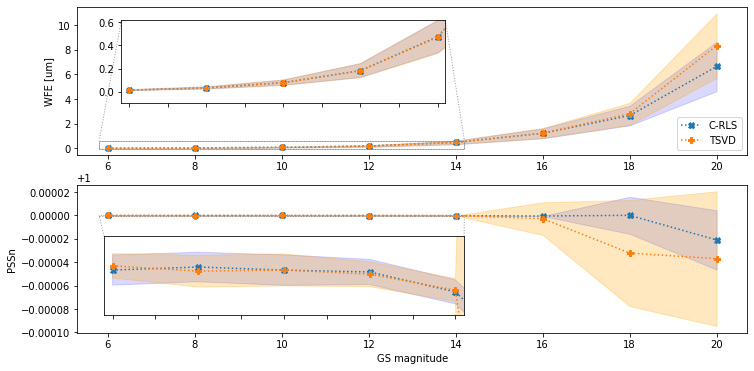

In [70]:
print('WFE RMS')
[print(k1,k2,k3,k4) for k1,k2,k3,k4 in zip(wfe_mean0p1,wfe_std0p1,wfe_mean0p1_,wfe_std0p1_)]
print('PSSn')
[print(k1,k2,k3,k4) for k1,k2,k3,k4 in zip(pssn_mean0p1,pssn_std0p1,pssn_mean0p1_,pssn_std0p1_)]

plt.figure(figsize=(12,6))
ax1 = plt.subplot(211)
ax1.set_ylabel('WFE [um]')
ax1.plot(mag_values,wfe_mean0p1,'X:', color='tab:blue', label='C-RLS')
ax1.fill_between(mag_values, wfe_mean0p1-wfe_std0p1, wfe_mean0p1+wfe_std0p1,
    alpha=0.15, edgecolor='blue', facecolor='blue')

ax1.plot(mag_values,wfe_mean0p1_,'P:', color='tab:orange', label='TSVD')
ax1.fill_between(mag_values, wfe_mean0p1_-wfe_std0p1_, wfe_mean0p1_+wfe_std0p1_,
    alpha=0.25, edgecolor='orange', facecolor='orange')

ax1.legend(loc='lower right')

axins = inset_axes(ax1, width=4.5, height=1.15, loc=2, bbox_to_anchor=(0.17,-0.14,1,1), 
                   bbox_transform=ax1.figure.transFigure)
    
axins.plot(mag_values,wfe_mean0p1,'X:', color='tab:blue')
axins.fill_between(mag_values, wfe_mean0p1-wfe_std0p1, wfe_mean0p1+wfe_std0p1,
    alpha=0.15, edgecolor='blue', facecolor='blue')

axins.plot(mag_values,wfe_mean0p1_,'P:', color='tab:orange')
axins.fill_between(mag_values, wfe_mean0p1_-wfe_std0p1_, wfe_mean0p1_+wfe_std0p1_,
    alpha=0.25, edgecolor='orange', facecolor='orange')


# Specify the limits
x1, x2, = 5.8, 14.2
y1 = -1.0e-1#0.3*min(min(wfe_mean0p1,wfe_mean0p2,wfe_mean0p1_,wfe_mean0p2_))
y2 = 1.3*max(np.hstack([wfe_mean0p1[:5],wfe_mean0p1_[:5],]))

axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
ax1.indicate_inset_zoom(axins)
mark_inset(ax1, axins, loc1=1, loc2=2, fc="none", ec="0.6", linestyle=":")
# Fix the number of ticks on the inset axes
plt.setp(axins.get_xticklabels(), visible=False)
plt.setp(axins.get_yticklabels(), visible=True)


#ax1.tick_params(axis='y')

### PSSn plot
ax2 = plt.subplot(212)
ax2.set_xlabel('GS magnitude')
ax2.set_ylabel('PSSn')

ax2.plot(mag_values,pssn_mean0p1,'X:', color='tab:blue', label='C-RLS')
ax2.fill_between(mag_values, pssn_mean0p1-pssn_std0p1, pssn_mean0p1+pssn_std0p1,
    alpha=0.15, edgecolor='blue', facecolor='blue')

ax2.plot(mag_values,pssn_mean0p1_,'P:', color='tab:orange', label='TSVD')
ax2.fill_between(mag_values, pssn_mean0p1_-pssn_std0p1_, pssn_mean0p1_+pssn_std0p1_,
    alpha=0.25, edgecolor='orange', facecolor='orange')

#ax2.legend()
#ax2.tick_params(axis='y',)

axins2 = inset_axes(ax2, width=5, height=1.1, loc=2, bbox_to_anchor=(0.15,-0.64,1,1), 
                   bbox_transform=ax2.figure.transFigure)
    
axins2.plot(mag_values,pssn_mean0p1,'X:', color='tab:blue')
axins2.fill_between(mag_values, pssn_mean0p1-pssn_std0p1, pssn_mean0p1+pssn_std0p1,
    alpha=0.15, edgecolor='blue', facecolor='blue')

axins2.plot(mag_values,pssn_mean0p1_,'P:', color='tab:orange')
axins2.fill_between(mag_values, pssn_mean0p1_-pssn_std0p1_, pssn_mean0p1_+pssn_std0p1_,
    alpha=0.25, edgecolor='orange', facecolor='orange')


# Specify the limits
x1, x2, = 5.8, 14.2
y1 = min(np.hstack([pssn_mean0p1[:5]-pssn_std0p1[:5],pssn_mean0p1_[:5],]-pssn_std0p1_[:5]))
y2 = max(np.hstack([pssn_mean0p1[:5]+pssn_std0p1[:5],pssn_mean0p1_[:5],]+pssn_std0p1_[:5]))

axins2.set_xlim(x1, x2) # apply the x-limits
axins2.set_ylim(y1, y2) # apply the y-limits
#ax2.indicate_inset_zoom(axins)    
# Fix the number of ticks on the inset axes
plt.setp(axins2.get_xticklabels(), visible=False)
plt.setp(axins2.get_yticklabels(), visible=False)
axins2.set_yticks([])
mark_inset(ax2, axins2, loc1=1, loc2=2, fc="none", ec="0.6", linestyle=":")

#plt.savefig('wfe_pssn_GSmag.png', format='png', dpi=300, bbox_inches='tight')

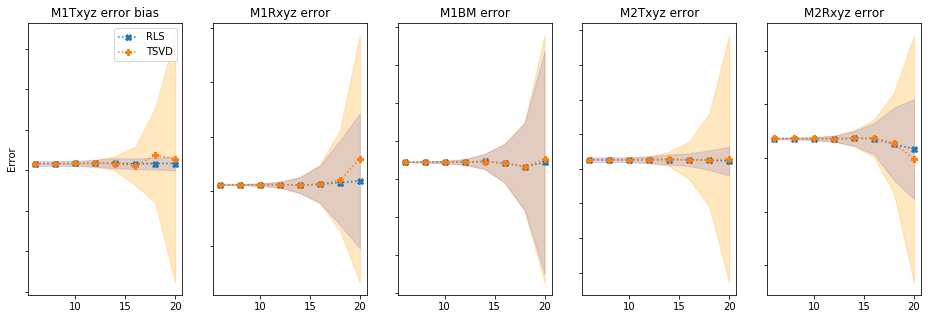

In [71]:
plt.figure(figsize=(16,5))
ax1 = plt.subplot(151)
ax1.set_title('M1Txyz error bias')
ax1.plot(mag_values,np.array(error_mean)[:,0],'X:', color='tab:blue', label='RLS')
ax1.fill_between(mag_values, np.array(error_mean)[:,0]-np.array(error_std)[:,0],
                 np.array(error_mean)[:,0]+np.array(error_std)[:,0],
                 alpha=0.15, edgecolor='blue', facecolor='blue')
ax1.plot(mag_values,np.array(error_mean_)[:,0],'P:', color='tab:orange', label='TSVD')
ax1.fill_between(mag_values, np.array(error_mean_)[:,0]-np.array(error_std_)[:,0],
                 np.array(error_mean_)[:,0]+np.array(error_std_)[:,0],
                 alpha=0.25, edgecolor='orange', facecolor='orange')
ax1.legend()
ax1.set_yticklabels([])
ax1.set_ylabel('Error')
ax1 = plt.subplot(152)
ax1.set_title('M1Rxyz error')
ax1.plot(mag_values,np.array(error_mean)[:,1],'X:', color='tab:blue')
ax1.fill_between(mag_values, np.array(error_mean)[:,1]-np.array(error_std)[:,1],
                 np.array(error_mean)[:,1]+np.array(error_std)[:,1],
                 alpha=0.15, edgecolor='blue', facecolor='blue')
ax1.plot(mag_values,np.array(error_mean_)[:,1],'P:', color='tab:orange')
ax1.fill_between(mag_values, np.array(error_mean_)[:,1]-np.array(error_std_)[:,1],
                 np.array(error_mean_)[:,1]+np.array(error_std_)[:,1],
                 alpha=0.25, edgecolor='orange', facecolor='orange')
ax1.set_yticklabels([])
ax1 = plt.subplot(153)
ax1.set_title('M1BM error')
ax1.plot(mag_values,np.array(error_mean)[:,2],'X:', color='tab:blue')
ax1.fill_between(mag_values, np.array(error_mean)[:,2]-np.array(error_std)[:,2],
                 np.array(error_mean)[:,2]+np.array(error_std)[:,2],
                 alpha=0.15, edgecolor='blue', facecolor='blue')
ax1.plot(mag_values,np.array(error_mean_)[:,2],'P:', color='tab:orange')
ax1.fill_between(mag_values, np.array(error_mean_)[:,2]-np.array(error_std_)[:,2],
                 np.array(error_mean_)[:,2]+np.array(error_std_)[:,2],
                 alpha=0.25, edgecolor='orange', facecolor='orange')
ax1.set_yticklabels([])
ax1 = plt.subplot(154)
ax1.set_title('M2Txyz error')
ax1.plot(mag_values,np.array(error_mean)[:,3],'X:', color='tab:blue')
ax1.fill_between(mag_values, np.array(error_mean)[:,3]-np.array(error_std)[:,3],
                 np.array(error_mean)[:,3]+np.array(error_std)[:,3],
                 alpha=0.15, edgecolor='blue', facecolor='blue')
ax1.plot(mag_values,np.array(error_mean_)[:,3],'P:', color='tab:orange')
ax1.fill_between(mag_values, np.array(error_mean_)[:,3]-np.array(error_std_)[:,3],
                 np.array(error_mean_)[:,3]+np.array(error_std_)[:,3],
                 alpha=0.25, edgecolor='orange', facecolor='orange')
ax1.set_yticklabels([])
ax1 = plt.subplot(155)
ax1.set_title('M2Rxyz error')
ax1.plot(mag_values,np.array(error_mean)[:,4],'X:', color='tab:blue')
ax1.fill_between(mag_values, np.array(error_mean)[:,4]-np.array(error_std)[:,4],
                 np.array(error_mean)[:,4]+np.array(error_std)[:,4],
                 alpha=0.15, edgecolor='blue', facecolor='blue')
ax1.plot(mag_values,np.array(error_mean_)[:,4],'P:', color='tab:orange')
ax1.fill_between(mag_values, np.array(error_mean_)[:,4]-np.array(error_std_)[:,4],
                 np.array(error_mean_)[:,4]+np.array(error_std_)[:,4],
                 alpha=0.25, edgecolor='orange', facecolor='orange')
ax1.set_yticklabels([])

#plt.savefig('recError_GSmag.png', format='png', dpi=300, bbox_inches='tight')

 #### Single test assessment

In [138]:
# Reload plot tools library
try:
    import importlib
    importlib.reload(dos.plot_tools)
except:
    import dos.plot_tools as ptools    

In [167]:
GSmag, K = 20, 0.25
n_w = 40
save_fig = True #False
filename = 'test_rbmplusbm_1_GS0_K0p25TSVDwosat.pickle'
#filename = 'test_rbmplusbm_1_GS0_K0p25TSVD.pickle'

with open(Path('testDT')/filename,'rb') as f:
    dt = pickle.load(f)
print('Loading test log file:%s'%filename)


Loading test log file:test_rbmplusbm_1_GS0_K0p25TSVDwosat.pickle



Final values:
 WFE (nm): [1.1500324] 
 [0.76953655 0.77421225 0.77493706 0.77246998 0.77160139 0.7720023
 0.17258393] 
PSSn: [0.99999996] 
sum of abs seg piston (um): 0.00595004130687915 
 [-0.00224133 -0.00027436 -0.00084138 -0.00014959 -0.00186119 -0.00019704
  0.00038515]


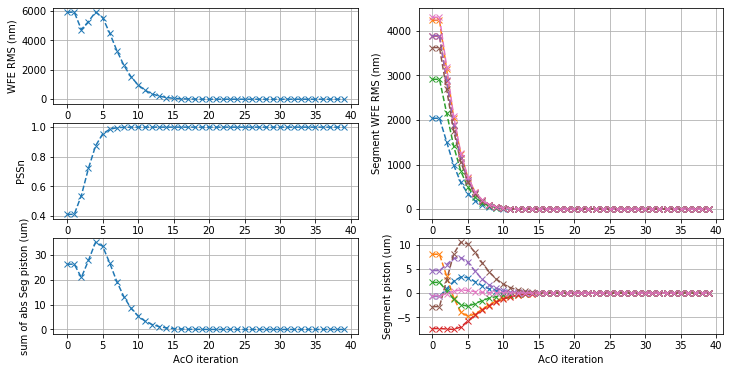

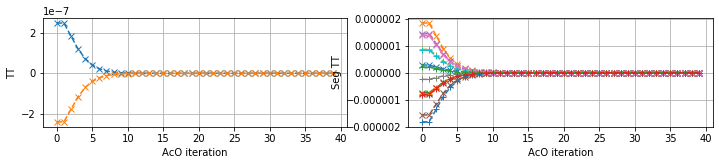

In [168]:
fig_1, fig_tt = ptools.plot_science(dt['sim_log_dt']['science'],n_w=n_w)
if(save_fig):
    #fig_1.savefig('wfe_pssn_example0.png', format='png', dpi=300, bbox_inches='tight')
    fig_1.savefig('wfe_pssn_example0wosat.png', format='png', dpi=300, bbox_inches='tight')

_rbmplusbm_1


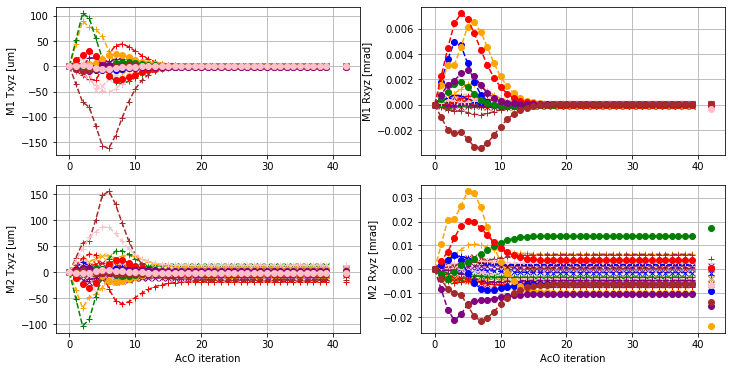

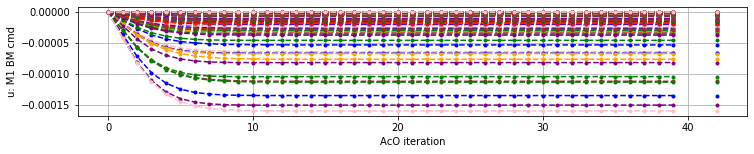

In [169]:
# Python code to set simulation states
from ruamel import yaml
from ruamel.yaml import YAML
m1m2load_folder = 'testDT/M1M2_loads'
r_id = 1

test_case = 'random' # 'random_RBM' # 'BM_dist' #

if(test_case == 'BM_dist'):
    fileSTR = '_2_3bm'
elif(test_case == 'random_RBM'):
    fileSTR = '_rand_rbm_%d' %r_id
elif(test_case == 'random'):
    fileSTR = '_rbmplusbm_%d' %r_id
else:
    fileSTR = '_noload' %r_id

print(fileSTR)

with open(Path(m1m2load_folder)/('M1'+fileSTR+'.yaml'),'r') as f:
    m1_x0_dt = yaml.safe_load(f)
with open(Path(m1m2load_folder)/('M2'+fileSTR+'.yaml'),'r') as f:
    m2_x0_dt = yaml.safe_load(f)
    
# Update yaml files with M1/M2 initial conditions    
with open(Path(sim_folder)/'M1.yaml','w') as f:
        y.dump(m1_x0_dt, f)
with open(Path(sim_folder)/'M2.yaml','w') as f:
        y.dump(m2_x0_dt, f)

U = dt['sim_log_dt']['SHAcO']
show_delta = False
fig_rbm, fig_bm = ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers, n_w=40)
if(save_fig):
    #fig_rbm.savefig('rbm_example0.png', format='png', dpi=300, bbox_inches='tight')
    #fig_bm.savefig('bm_example0.png', format='png', dpi=300, bbox_inches='tight')
    fig_rbm.savefig('rbm_example0wosat.png', format='png', dpi=300, bbox_inches='tight')
    fig_bm.savefig('bm_example0wosat.png', format='png', dpi=300, bbox_inches='tight')

Bending modes' data

In [170]:
import os
from os import path
import scipy.io as spio

n_bm = 27
max_Fz = 147

Afz = {}

# OA segment weights
filepath = os.path.join('../ActiveOptics','Af_oa_axial_ver3.mat')
Afz['outer'] = spio.loadmat(filepath)['afprime']
_U,s_oa,V_oaT = np.linalg.svd(Afz['outer'],0)
bm2Fz_oa = np.dot(V_oaT.T, np.diag(1/s_oa)[:,:n_bm])
# CS (center segment) weights
filepath = os.path.join('../ActiveOptics','Af_cs154_axial.mat')
Afz['center'] = spio.loadmat(filepath)['afprime']
_U,s_cs,V_csT = np.linalg.svd(Afz['center'],0)
bm2Fz_cs = np.dot(V_csT.T, np.diag(1/s_cs)[:,:n_bm])

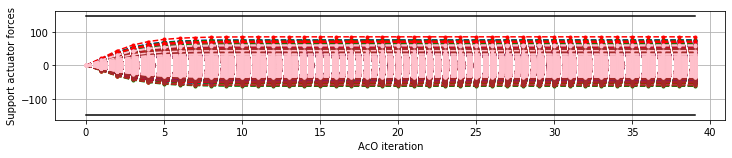

In [171]:
BM_ = dt['sim_log_dt']['SHAcO']['M1 BM'].timeSeries
fig_Fz = plt.figure(figsize=(12,2))
for kseg in range(6):
    plt.plot(np.arange(0,n_w),bm2Fz_oa.dot(BM_[1][kseg,:,:]).T[0:n_w,:],'--.',color=colors[kseg])
plt.plot(np.arange(0,n_w),bm2Fz_cs.dot(BM_[1][6,:,:]).T[0:n_w,:],'--.',color=colors[6])
plt.plot(np.arange(0,n_w),max_Fz*np.ones(BM_[0][0:n_w].shape),'k')
plt.plot(np.arange(0,n_w),-max_Fz*np.ones(BM_[0][0:n_w].shape),'k')
plt.ylabel('Support actuator forces')
plt.xlabel('AcO iteration')
plt.grid()
plt.show()
if(save_fig):
    #fig_Fz.savefig('Fz_example0.png', format='png', dpi=300, bbox_inches='tight')
    fig_Fz.savefig('Fz_example0wosat.png', format='png', dpi=300, bbox_inches='tight')